In [3]:
# @title Generic Imports
from IPython.display import Audio, display
import os
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from urllib.request import urlopen
from tqdm import tnrange, tqdm_notebook, tqdm
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [4]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [5]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  device = "mps" if torch.backends.mps.is_available() else "cpu"
  if device == "cuda":
    print("GPU is enabled in this notebook.")
  elif device == "mps":
    print("Metal is enabled in this notebook.")


  return device


In [6]:
# @title Set SEED to 2024: `set_seed()`
# especially if torch modules used.
SEED = 2024
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2024 has been set.
Metal is enabled in this notebook.


# Download the CREMA-D dataset

In [7]:
DATA='../data'
CREMA_D_DATA='../data/CREMA-D'
CREMA_AUDIO_DATA=f'{CREMA_D_DATA}/AudioWAV'

if not os.stat(CREMA_D_DATA):
    os.exec(f'git lfs clone https://github.com/CheyneyComputerScience/CREMA-D.git {CREMA_D_DATA}')

In [8]:
print(os.listdir(CREMA_AUDIO_DATA))

['1022_ITS_ANG_XX.wav', '1037_ITS_ANG_XX.wav', '1060_ITS_NEU_XX.wav', '1075_ITS_NEU_XX.wav', '1073_IOM_DIS_XX.wav', '1066_IOM_DIS_XX.wav', '1078_IWL_SAD_XX.wav', '1029_TAI_FEA_XX.wav', '1039_IEO_SAD_MD.wav', '1008_TAI_HAP_XX.wav', '1018_TSI_FEA_XX.wav', '1028_IEO_SAD_HI.wav', '1039_TSI_HAP_XX.wav', '1064_ITS_HAP_XX.wav', '1071_ITS_HAP_XX.wav', '1045_ITS_FEA_XX.wav', '1050_ITS_FEA_XX.wav', '1018_IWL_ANG_XX.wav', '1059_IEO_ANG_MD.wav', '1054_MTI_DIS_XX.wav', '1041_MTI_DIS_XX.wav', '1048_IEO_ANG_HI.wav', '1042_ITS_SAD_XX.wav', '1019_TAI_NEU_XX.wav', '1057_ITS_SAD_XX.wav', '1028_TSI_NEU_XX.wav', '1087_IOM_ANG_XX.wav', '1039_IEO_HAP_LO.wav', '1018_IEO_FEA_LO.wav', '1079_DFA_NEU_XX.wav', '1063_IWW_DIS_XX.wav', '1076_IWW_DIS_XX.wav', '1068_WSI_HAP_XX.wav', '1049_WSI_FEA_XX.wav', '1059_ITH_DIS_XX.wav', '1068_DFA_HAP_XX.wav', '1049_DFA_FEA_XX.wav', '1079_WSI_NEU_XX.wav', '1082_IWW_ANG_XX.wav', '1061_ITH_NEU_XX.wav', '1074_ITH_NEU_XX.wav', '1023_ITH_ANG_XX.wav', '1036_ITH_ANG_XX.wav', '1005_IEO_

In [9]:
import glob
import re

def _match_crema_d_regex(file):
    """
    eg. `1005_IWW_DIS_XX.wav` -> `{actor: 1005, phrase: 'IWW', emotion: 'DIS', intensity: 'XX'}`
    """
    crema_d_regex="([0-9]{4})_([a-z,A-Z]{3})_([a-z,A-Z]{3})_([a-z,A-Z]{2})"
    r = re.match(f'{CREMA_AUDIO_DATA}/{crema_d_regex}.wav', file)
    return {'filename': file, 'actor': r.group(1), 'phrase': r.group(2), 'emotion': r.group(3), 'intensity': r.group(4)}

crema_list = list(map(_match_crema_d_regex, glob.glob(f'{CREMA_AUDIO_DATA}/**.wav', recursive=False)))
print(crema_list)


[{'filename': '../data/CREMA-D/AudioWAV/1022_ITS_ANG_XX.wav', 'actor': '1022', 'phrase': 'ITS', 'emotion': 'ANG', 'intensity': 'XX'}, {'filename': '../data/CREMA-D/AudioWAV/1037_ITS_ANG_XX.wav', 'actor': '1037', 'phrase': 'ITS', 'emotion': 'ANG', 'intensity': 'XX'}, {'filename': '../data/CREMA-D/AudioWAV/1060_ITS_NEU_XX.wav', 'actor': '1060', 'phrase': 'ITS', 'emotion': 'NEU', 'intensity': 'XX'}, {'filename': '../data/CREMA-D/AudioWAV/1075_ITS_NEU_XX.wav', 'actor': '1075', 'phrase': 'ITS', 'emotion': 'NEU', 'intensity': 'XX'}, {'filename': '../data/CREMA-D/AudioWAV/1073_IOM_DIS_XX.wav', 'actor': '1073', 'phrase': 'IOM', 'emotion': 'DIS', 'intensity': 'XX'}, {'filename': '../data/CREMA-D/AudioWAV/1066_IOM_DIS_XX.wav', 'actor': '1066', 'phrase': 'IOM', 'emotion': 'DIS', 'intensity': 'XX'}, {'filename': '../data/CREMA-D/AudioWAV/1078_IWL_SAD_XX.wav', 'actor': '1078', 'phrase': 'IWL', 'emotion': 'SAD', 'intensity': 'XX'}, {'filename': '../data/CREMA-D/AudioWAV/1029_TAI_FEA_XX.wav', 'actor'

## Create the Spectrogram transformation

In [10]:
import torch.nn as nn
import torchaudio

class SpecTransform(nn.Module):
    """
    This module takes
    """

    def __init__(self, sr=16000, n_fft=2048):
        super().__init__()
        self.n_fft=n_fft
        self.sr=sr

        self.mel = torchaudio.transforms.MelSpectrogram(sample_rate=self.sr, n_fft=self.n_fft, n_mels=512)

    def forward(self, x):
        with torch.no_grad():
            return(self.mel(x))

# Create the dataset wrapper

1. List the contents of the file folder and store the names of the files ".wav" as a dictionary.
2. Decompose each file title into the label information it contains, eg. `1005_IWW_DIS_XX.wav` -> `{actor: 1005, phrase: 'IWW', emotion: 'DIS', intensity: 'XX'}`
3. Create a loader of the data.
4. Create a transformation for the corresponding CNN input.

In [11]:
# We will create necessary transformations assuming the files are mono-channel.

import torch.utils
import torch
import torch.utils.data
import torchaudio
from torchaudio.transforms import Resample
import torch.nn.functional as F
import random
import re
import glob
import os

class CREMA_DDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            path,
            seq_duration=None,
            n_fft=2048,
            sr=44100,
            size=224,
            preprocessor=None
    ):
      """CREMA-D Dataset wrapper.
      args:
      path: file directory where samples are labeled by genre
      seq_duration: duration in seconds: float
      """
      super().__init__()
      self.seq_duration = seq_duration
      self.files = self._retrieve_paths(path)
      self.sr=sr
      self.size=size
      self.spec=SpecTransform(n_fft=n_fft)
      self.resample=Resample(new_freq=self.sr)
      self.preprocessor = preprocessor
      self.emotion = ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']
      self.intensity = ['LO', 'MD', 'HI', 'XX']
      self.category = {k: num for num, k in enumerate([i+j for i in self.emotion for j in self.intensity])}

    def _retrieve_paths(self, path):
      """
      Retrieves all matching files in path with CREMA-D specification.
      It returns a dict {path: label}
      """
      assert os.stat(path) is not False

      files_list = glob.glob(f'{path}/**.wav', recursive=False)
      print(files_list)

      return files_list

    def _match_crema_d_regex(self, file):
        """
        eg. `1005_IWW_DIS_XX.wav` -> `{actor: 1005, phrase: 'IWW', emotion: 'DIS', intensity: 'XX'}`
        """
        crema_d_regex="([0-9]{4})_([a-z,A-Z]{3})_([a-z,A-Z]{3})_([a-z,A-Z]{2})"
        r = re.match(f'{CREMA_AUDIO_DATA}/{crema_d_regex}.wav', file)
        return {'actor': r.group(1), 'phrase': r.group(2), 'emotion': r.group(3), 'intensity': r.group(4)}

    def __getitem__(self, index):
      item = self.files[index]
      track, sr = torchaudio.load(item)
      track_duration = track.shape[0] / sr

      if self.seq_duration is None:
        self.seq_duration = track_duration

      chunk_start = max(0, random.uniform(0, track_duration - self.seq_duration)) # Prevents rounding errors
      track = track[0][int(chunk_start * sr) : int((chunk_start + self.seq_duration) * sr)]
      x = torch.cat((track.unsqueeze(0), track.unsqueeze(0)), dim=0)

      y_dict = self._match_crema_d_regex(item)
      y = (y_dict['emotion'], y_dict['intensity'])

      self.resample.orig_freq = sr
      resampled_x = self.resample(torch.Tensor(x))
      spec_x = self.spec(resampled_x)

      if self.preprocessor is not None:
        spec_x = self.preprocessor(spec_x.to(DEVICE)).cpu()

      return self._transform_cnn(spec_x), self.category[y[0]+y[1]]


    def _transform_cnn(self, x):
      """
    Takes stereo spectogram and adds a third averaged channel to be compatible
    for cnn.
    """
      out = torch.cat((x, x[0].unsqueeze(0)), dim=0)
      res_img = F.interpolate(out.unsqueeze(0), size=(self.size, self.size), mode='bilinear', align_corners=False).squeeze(0)
      return res_img

    def __len__(self):
      return len(self.files)

In [12]:
track, sr = torchaudio.load(CREMA_AUDIO_DATA+'/'+random.choice(os.listdir(CREMA_AUDIO_DATA)), backend="soundfile")
print(track[0], sr)

tensor([-0.0041, -0.0033, -0.0019,  ...,  0.0000,  0.0000,  0.0000]) 16000


## Create the CREMA-D Dataset

In [13]:
crema_d = CREMA_DDataset(CREMA_AUDIO_DATA,
                     seq_duration=2)

print(f'Size of Dataset {len(crema_d)}')

['../data/CREMA-D/AudioWAV/1022_ITS_ANG_XX.wav', '../data/CREMA-D/AudioWAV/1037_ITS_ANG_XX.wav', '../data/CREMA-D/AudioWAV/1060_ITS_NEU_XX.wav', '../data/CREMA-D/AudioWAV/1075_ITS_NEU_XX.wav', '../data/CREMA-D/AudioWAV/1073_IOM_DIS_XX.wav', '../data/CREMA-D/AudioWAV/1066_IOM_DIS_XX.wav', '../data/CREMA-D/AudioWAV/1078_IWL_SAD_XX.wav', '../data/CREMA-D/AudioWAV/1029_TAI_FEA_XX.wav', '../data/CREMA-D/AudioWAV/1039_IEO_SAD_MD.wav', '../data/CREMA-D/AudioWAV/1008_TAI_HAP_XX.wav', '../data/CREMA-D/AudioWAV/1018_TSI_FEA_XX.wav', '../data/CREMA-D/AudioWAV/1028_IEO_SAD_HI.wav', '../data/CREMA-D/AudioWAV/1039_TSI_HAP_XX.wav', '../data/CREMA-D/AudioWAV/1064_ITS_HAP_XX.wav', '../data/CREMA-D/AudioWAV/1071_ITS_HAP_XX.wav', '../data/CREMA-D/AudioWAV/1045_ITS_FEA_XX.wav', '../data/CREMA-D/AudioWAV/1050_ITS_FEA_XX.wav', '../data/CREMA-D/AudioWAV/1018_IWL_ANG_XX.wav', '../data/CREMA-D/AudioWAV/1059_IEO_ANG_MD.wav', '../data/CREMA-D/AudioWAV/1054_MTI_DIS_XX.wav', '../data/CREMA-D/AudioWAV/1041_MTI_DIS_

/Users/etrujillo/Documents/20 src/coffee_and_crema/.venv/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (512) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(


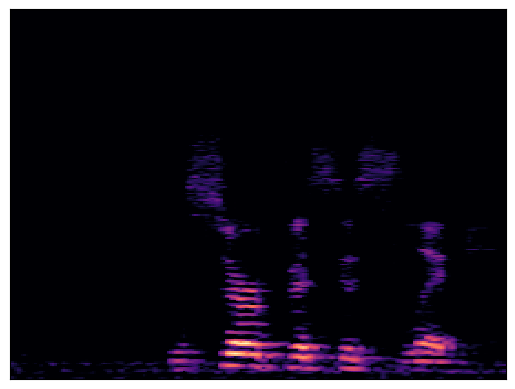

In [14]:
# @title Sample Spectrogram (resized for CNN)
from torch.utils.data import DataLoader, RandomSampler
import librosa
data = random.choice(crema_d)

librosa.display.specshow(librosa.amplitude_to_db(np.abs(data[0][0].detach().numpy()), ref=np.max))

## Create ResNet

In [15]:
import torch
import torch.nn as nn

from typing import Type
from torch import Tensor

In [16]:
class BasicBlock(nn.Module):
    def  __init__(
            self,
            in_channels: int,
            out_channels: int,
            stride: int = 1,
            expansion: int = 1,
            downsample: nn.Module = None
    ) -> None:
        super(BasicBlock, self).__init__()
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride = stride,
            padding = 1,
            bias = False  # Can change it to true
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True) # can change it to GELU
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels*self.expansion,
            kernel_size = 3,
            padding = 1,
            bias=False  # can change this
        )
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)
        # expansion = 1 in resnet 18 because the output
        # tensor size wont change within a block for this architecture.

    def forward(self, x: Tensor) -> Tensor:
        identity = x  # this is the skip connection

        # first block layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        # second block layer
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            # if we want to reduce the number of parameters
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out


In [17]:
class ResNet(nn.Module):
    def __init__(
            self,
            img_channels:int,
            num_layers: int,
            block: Type[BasicBlock],
            num_classes: int = 10  # depends on our final output
    ) -> None:
        super(ResNet, self).__init__()
        # The following `layers` list defines the number of basic blocks
        # to use to build the network and how many basic blocks to stack
        # together.
        if num_layers == 18:
            layers = [2, 2, 2, 2]
            self.expansion = 1
        elif num_layers == 10:
            layers = [1, 1, 1, 1]
            self.expansion = 1

        self.in_channels = 32
        # normally its 64, can change this to 32, then we will have [32, 64, 128, 256]
        # but resnet uses [64, 128, 256, 512] so its a choice, more kernels
        # does not mean a good model

        # layer 1
        self.conv1 = nn.Conv2d(
            in_channels = img_channels,
            out_channels = self.in_channels,
            kernel_size = 7,
            stride = 2,
            padding = 3,
            bias = False
        )
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer2 = self._make_layer(block, 32, layers[0])
        self.layer3 = self._make_layer(block, 32*2, layers[1], stride=2) # downsampling
        self.layer4 = self._make_layer(block, 32*4, layers[2], stride=2)
        self.layer5 = self._make_layer(block, 32*8, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256*self.expansion, num_classes)
        # if self.in_channels were 32 this would be 256*self.expansion, num_classes

    def _make_layer(
            self,
            block: Type[BasicBlock],
            out_channels: int,
            blocks: int,
            stride: int = 1
    ) -> nn.Sequential:
        downsample = None
        if stride != 1:
            """
            This should pass from `layer2` to `layer4` or
            when building ResNets50 and above. Section 3.3 of the paper
            Deep Residual Learning for Image Recognition
            (https://arxiv.org/pdf/1512.03385v1.pdf).
            """
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample
            )
        )
        self.in_channels = out_channels * self.expansion
        for i in range(1, blocks):
            layers.append(block(
                self.in_channels,
                out_channels,
                expansion=self.expansion
            ))
        return nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        # the spatial dimension of the final layer's feature
        # map should be (7, 7) for all ResNets.
        # print('Dimensions of the last convolutional feature map: ', x.shape)
        # comment the above statement after training

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


### Create a ResNet 18 Model

In [18]:
# Resnet 18
model = ResNet(img_channels=3, num_layers=18, block=BasicBlock, num_classes=24)
print(model)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
output = model(data[0].unsqueeze(0))
print(output)

ResNet(
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training

In [19]:
SAVE_PATH='../checkpoints'

# checkpoint & adjust_learning_rate
def checkpoint(model, acc, epoch, outModelName):
  # Save checkpoint.
  print('Saving..')
  state = {
      'state_dict': model.state_dict(),
      'acc': acc,
      'epoch': epoch,
      'rng_state': torch.get_rng_state()
  }
  if not os.path.isdir(f'{SAVE_PATH}/checkpoint'):
      os.mkdir(f'{SAVE_PATH}/checkpoint')
  torch.save(state, f'{SAVE_PATH}/checkpoint/{outModelName}.t7')

def load_checkpoint(path):
  if os.stat(path) is not None:
    model = torch.load(path)
    print("Model loaded!")
    return model
  return None

In [20]:
# resnet training loop

def resnet_train(model,
                 device,
                 train_loader,
                 validation_loader,
                 epochs,
                 model_name='resnet18'):
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
  criterion = nn.CrossEntropyLoss()

  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []

  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      # Training Phase
      model.train()  # Ensure model is in training mode at the start of each epoch
      print("Model in training mode:", model.training)  # Check if the entire model is in training mode
      running_loss = 0.
      correct, total = 0, 0

      for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      train_loss.append(running_loss / len(train_loader))
      train_acc.append(correct / total)

      # Validation Phase
      model.eval()  # Set model to evaluation mode for validation
      print("Model in eval mode:", not model.training)  # Check if the entire model is in eval mode
      running_loss = 0.
      correct, total = 0, 0

      with torch.no_grad():  # No need to calculate gradients during validation
        for data, target in validation_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          loss = criterion(output, target)
          tepochs.set_postfix(loss=loss.item())
          running_loss += loss.item()

          _, predicted = torch.max(output, 1)
          total += target.size(0)
          correct += (predicted == target).sum().item()

      validation_loss.append(running_loss / len(validation_loader))
      validation_acc.append(correct / total)
      checkpoint(model,
                 acc=correct / total,
                 epoch=epoch,
                 outModelName=model_name)

  return train_loss, train_acc, validation_loss, validation_acc

### Create Dataset Splits

In [21]:
from torch.utils.data import DataLoader

random_state = torch.Generator().manual_seed(SEED)

crema_d_train = DataLoader(crema_d, batch_size=8, shuffle=True)
train_set, test_set, holdout_set = torch.utils.data.random_split(crema_d, [0.7, 0.15, 0.15], random_state)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
test_loader = DataLoader(test_set, batch_size=8, shuffle=True)

### Train the model

In [23]:
#model.load_state_dict(load_checkpoint(f'{SAVE_PATH}/checkpoint/resnet18-direct.t7')['state_dict'])
for _ in range(10):
  resnet_losses = resnet_train(
    model, device=DEVICE,
    model_name='resnet18-direct',
    train_loader=train_loader,
    validation_loader=test_loader,
    epochs=20)

Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

Model in training mode: True


Training:   0%|          | 0/20 [00:41<?, ?epoch/s, loss=1.47]

Model in eval mode: True


Training:   5%|▌         | 1/20 [00:46<14:40, 46.36s/epoch, loss=1.39]

Saving..
Model in training mode: True


Training:   5%|▌         | 1/20 [01:19<14:40, 46.36s/epoch, loss=1.61]

Model in eval mode: True


Training:  10%|█         | 2/20 [01:24<12:26, 41.48s/epoch, loss=3.14]

Saving..
Model in training mode: True


Training:  10%|█         | 2/20 [01:57<12:26, 41.48s/epoch, loss=4.46]

Model in eval mode: True


Training:  15%|█▌        | 3/20 [02:02<11:19, 39.98s/epoch, loss=1.67]

Saving..
Model in training mode: True


Training:  15%|█▌        | 3/20 [02:36<11:19, 39.98s/epoch, loss=5.45]

Model in eval mode: True


Training:  20%|██        | 4/20 [02:42<10:36, 39.81s/epoch, loss=3.27]

Saving..
Model in training mode: True


Training:  20%|██        | 4/20 [03:16<10:36, 39.81s/epoch, loss=3.33]

Model in eval mode: True


Training:  25%|██▌       | 5/20 [03:22<09:57, 39.84s/epoch, loss=3.44] 

Saving..
Model in training mode: True


Training:  25%|██▌       | 5/20 [03:56<09:57, 39.84s/epoch, loss=5.57]

Model in eval mode: True


Training:  30%|███       | 6/20 [04:02<09:18, 39.89s/epoch, loss=5.16]

Saving..
Model in training mode: True


Training:  30%|███       | 6/20 [04:38<09:18, 39.89s/epoch, loss=3.19]

Model in eval mode: True


Training:  35%|███▌      | 7/20 [04:44<08:49, 40.71s/epoch, loss=3.81]

Saving..
Model in training mode: True


Training:  35%|███▌      | 7/20 [05:22<08:49, 40.71s/epoch, loss=2.93]

Model in eval mode: True


Training:  40%|████      | 8/20 [05:29<08:23, 41.96s/epoch, loss=3.97]

Saving..
Model in training mode: True


Training:  40%|████      | 8/20 [06:08<08:23, 41.96s/epoch, loss=4.9] 

Model in eval mode: True


Training:  45%|████▌     | 9/20 [06:14<07:52, 42.96s/epoch, loss=6.89]

Saving..
Model in training mode: True


Training:  45%|████▌     | 9/20 [06:53<07:52, 42.96s/epoch, loss=3.85]

Model in eval mode: True


Training:  50%|█████     | 10/20 [07:00<07:18, 43.85s/epoch, loss=7.73]

Saving..
Model in training mode: True


Training:  50%|█████     | 10/20 [07:39<07:18, 43.85s/epoch, loss=3.13]

Model in eval mode: True


Training:  55%|█████▌    | 11/20 [07:46<06:40, 44.52s/epoch, loss=4.27]

Saving..
Model in training mode: True


Training:  55%|█████▌    | 11/20 [08:26<06:40, 44.52s/epoch, loss=2.58]

Model in eval mode: True


Training:  60%|██████    | 12/20 [08:32<06:00, 45.09s/epoch, loss=3.73]

Saving..
Model in training mode: True


Training:  60%|██████    | 12/20 [09:13<06:00, 45.09s/epoch, loss=5.15]

Model in eval mode: True


Training:  65%|██████▌   | 13/20 [09:19<05:19, 45.67s/epoch, loss=4.58] 

Saving..
Model in training mode: True


Training:  65%|██████▌   | 13/20 [10:00<05:19, 45.67s/epoch, loss=2.14]

Model in eval mode: True


Training:  70%|███████   | 14/20 [10:07<04:37, 46.29s/epoch, loss=5.23]

Saving..
Model in training mode: True


Training:  70%|███████   | 14/20 [10:48<04:37, 46.29s/epoch, loss=9.73]

Model in eval mode: True


Training:  75%|███████▌  | 15/20 [10:54<03:53, 46.71s/epoch, loss=8.94] 

Saving..
Model in training mode: True


Training:  75%|███████▌  | 15/20 [11:36<03:53, 46.71s/epoch, loss=11.7]

Model in eval mode: True


Training:  80%|████████  | 16/20 [11:42<03:08, 47.07s/epoch, loss=8.9] 

Saving..
Model in training mode: True


Training:  80%|████████  | 16/20 [12:24<03:08, 47.07s/epoch, loss=11.5]

Model in eval mode: True


Training:  85%|████████▌ | 17/20 [12:31<02:22, 47.45s/epoch, loss=5.59]

Saving..
Model in training mode: True


Training:  85%|████████▌ | 17/20 [13:14<02:22, 47.45s/epoch, loss=11.2]

Model in eval mode: True


Training:  90%|█████████ | 18/20 [13:20<01:35, 47.97s/epoch, loss=11.2]

Saving..
Model in training mode: True


Training:  90%|█████████ | 18/20 [14:03<01:35, 47.97s/epoch, loss=6.03]

Model in eval mode: True


Training:  95%|█████████▌| 19/20 [14:10<00:48, 48.50s/epoch, loss=9.68]

Saving..
Model in training mode: True


Training:  95%|█████████▌| 19/20 [14:52<00:48, 48.50s/epoch, loss=8.04]

Model in eval mode: True


Training: 100%|██████████| 20/20 [14:59<00:00, 44.95s/epoch, loss=6.79]


Saving..


Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

Model in training mode: True


Training:   0%|          | 0/20 [00:42<?, ?epoch/s, loss=14.5]

Model in eval mode: True


Training:   5%|▌         | 1/20 [00:48<15:24, 48.64s/epoch, loss=13.4]

Saving..
Model in training mode: True


Training:   5%|▌         | 1/20 [01:31<15:24, 48.64s/epoch, loss=19.2]

Model in eval mode: True


Training:  10%|█         | 2/20 [01:38<14:43, 49.10s/epoch, loss=17.6]

Saving..
Model in training mode: True


Training:  10%|█         | 2/20 [02:22<14:43, 49.10s/epoch, loss=6.24]

Model in eval mode: True


Training:  15%|█▌        | 3/20 [02:28<14:07, 49.84s/epoch, loss=9.46]

Saving..
Model in training mode: True


Training:  15%|█▌        | 3/20 [03:12<14:07, 49.84s/epoch, loss=6.75]

Model in eval mode: True


Training:  20%|██        | 4/20 [03:18<13:19, 49.94s/epoch, loss=10.4]

Saving..
Model in training mode: True


Training:  20%|██        | 4/20 [04:02<13:19, 49.94s/epoch, loss=12.9]

Model in eval mode: True


Training:  25%|██▌       | 5/20 [04:08<12:29, 50.00s/epoch, loss=17]  

Saving..
Model in training mode: True


Training:  25%|██▌       | 5/20 [04:53<12:29, 50.00s/epoch, loss=17.6]

Model in eval mode: True


Training:  30%|███       | 6/20 [05:00<11:47, 50.51s/epoch, loss=19.9]

Saving..
Model in training mode: True


Training:  30%|███       | 6/20 [05:45<11:47, 50.51s/epoch, loss=13.8]

Model in eval mode: True


Training:  35%|███▌      | 7/20 [05:51<10:58, 50.68s/epoch, loss=18.3]

Saving..
Model in training mode: True


Training:  35%|███▌      | 7/20 [06:37<10:58, 50.68s/epoch, loss=8.96]

Model in eval mode: True


Training:  40%|████      | 8/20 [06:43<10:13, 51.16s/epoch, loss=14.5]

Saving..
Model in training mode: True


Training:  40%|████      | 8/20 [07:32<10:13, 51.16s/epoch, loss=16.3]

Model in eval mode: True


Training:  45%|████▌     | 9/20 [07:39<09:37, 52.50s/epoch, loss=17]  

Saving..
Model in training mode: True


Training:  45%|████▌     | 9/20 [08:28<09:37, 52.50s/epoch, loss=13]

Model in eval mode: True


Training:  50%|█████     | 10/20 [08:34<08:55, 53.50s/epoch, loss=10.6]

Saving..
Model in training mode: True


Training:  50%|█████     | 10/20 [09:21<08:55, 53.50s/epoch, loss=9.15]

Model in eval mode: True


Training:  55%|█████▌    | 11/20 [09:27<08:00, 53.37s/epoch, loss=5.46]

Saving..
Model in training mode: True


Training:  55%|█████▌    | 11/20 [10:13<08:00, 53.37s/epoch, loss=13.7]

Model in eval mode: True


Training:  60%|██████    | 12/20 [10:20<07:05, 53.15s/epoch, loss=19.7]

Saving..
Model in training mode: True


Training:  60%|██████    | 12/20 [11:09<07:05, 53.15s/epoch, loss=7.74]

Model in eval mode: True


Training:  65%|██████▌   | 13/20 [11:16<06:17, 53.94s/epoch, loss=9.72]

Saving..
Model in training mode: True


Training:  65%|██████▌   | 13/20 [12:05<06:17, 53.94s/epoch, loss=8.69]

Model in eval mode: True


Training:  70%|███████   | 14/20 [12:13<05:29, 54.86s/epoch, loss=4.47]

Saving..
Model in training mode: True


Training:  70%|███████   | 14/20 [13:02<05:29, 54.86s/epoch, loss=6.96]

Model in eval mode: True


Training:  75%|███████▌  | 15/20 [13:09<04:35, 55.19s/epoch, loss=8.58]

Saving..
Model in training mode: True


Training:  75%|███████▌  | 15/20 [13:56<04:35, 55.19s/epoch, loss=8.82]

Model in eval mode: True


Training:  80%|████████  | 16/20 [14:03<03:39, 54.89s/epoch, loss=7.84]

Saving..
Model in training mode: True


Training:  80%|████████  | 16/20 [14:51<03:39, 54.89s/epoch, loss=13.6]

Model in eval mode: True


Training:  85%|████████▌ | 17/20 [14:57<02:44, 54.72s/epoch, loss=13.2]

Saving..
Model in training mode: True


Training:  85%|████████▌ | 17/20 [15:46<02:44, 54.72s/epoch, loss=10.1]

Model in eval mode: True


Training:  90%|█████████ | 18/20 [15:53<01:50, 55.15s/epoch, loss=13]  

Saving..
Model in training mode: True


Training:  90%|█████████ | 18/20 [16:47<01:50, 55.15s/epoch, loss=8.72]

Model in eval mode: True


Training:  95%|█████████▌| 19/20 [16:54<00:56, 56.69s/epoch, loss=14]  

Saving..
Model in training mode: True


Training:  95%|█████████▌| 19/20 [17:39<00:56, 56.69s/epoch, loss=22.2]

Model in eval mode: True


Training: 100%|██████████| 20/20 [17:46<00:00, 53.32s/epoch, loss=13]  


Saving..


Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

Model in training mode: True


Training:   0%|          | 0/20 [00:44<?, ?epoch/s, loss=6.47]

Model in eval mode: True


Training:   5%|▌         | 1/20 [00:51<16:17, 51.43s/epoch, loss=11.9]

Saving..
Model in training mode: True


Training:   5%|▌         | 1/20 [01:42<16:17, 51.43s/epoch, loss=19.4]

Model in eval mode: True


Training:  10%|█         | 2/20 [01:49<16:36, 55.36s/epoch, loss=24.8]

Saving..
Model in training mode: True


Training:  10%|█         | 2/20 [02:34<16:36, 55.36s/epoch, loss=8.95]

Model in eval mode: True


Training:  15%|█▌        | 3/20 [02:41<15:11, 53.59s/epoch, loss=5.29]

Saving..
Model in training mode: True


Training:  15%|█▌        | 3/20 [03:27<15:11, 53.59s/epoch, loss=14.8]

Model in eval mode: True


Training:  20%|██        | 4/20 [03:34<14:14, 53.42s/epoch, loss=16.5]

Saving..
Model in training mode: True


Training:  20%|██        | 4/20 [04:21<14:14, 53.42s/epoch, loss=14.9]

Model in eval mode: True


Training:  25%|██▌       | 5/20 [04:27<13:22, 53.52s/epoch, loss=15.4]

Saving..
Model in training mode: True


Training:  25%|██▌       | 5/20 [05:13<13:22, 53.52s/epoch, loss=15.3]

Model in eval mode: True


Training:  30%|███       | 6/20 [05:19<12:22, 53.01s/epoch, loss=9.05]

Saving..
Model in training mode: True


Training:  30%|███       | 6/20 [06:09<12:22, 53.01s/epoch, loss=16.1]

Model in eval mode: True


Training:  35%|███▌      | 7/20 [06:16<11:45, 54.26s/epoch, loss=24.3]

Saving..
Model in training mode: True


Training:  35%|███▌      | 7/20 [07:02<11:45, 54.26s/epoch, loss=14.8]

Model in eval mode: True


Training:  40%|████      | 8/20 [07:08<10:42, 53.57s/epoch, loss=10.4]

Saving..
Model in training mode: True


Training:  40%|████      | 8/20 [07:52<10:42, 53.57s/epoch, loss=14.1]

Model in eval mode: True


Training:  45%|████▌     | 9/20 [07:58<09:37, 52.48s/epoch, loss=17.4]

Saving..
Model in training mode: True


Training:  45%|████▌     | 9/20 [08:43<09:37, 52.48s/epoch, loss=13.4]

Model in eval mode: True


Training:  50%|█████     | 10/20 [08:49<08:38, 51.84s/epoch, loss=16.5]

Saving..
Model in training mode: True


Training:  50%|█████     | 10/20 [09:33<08:38, 51.84s/epoch, loss=13.2]

Model in eval mode: True


Training:  55%|█████▌    | 11/20 [09:39<07:42, 51.34s/epoch, loss=10]  

Saving..
Model in training mode: True


Training:  55%|█████▌    | 11/20 [10:23<07:42, 51.34s/epoch, loss=12.1]

Model in eval mode: True


Training:  60%|██████    | 12/20 [10:30<06:48, 51.10s/epoch, loss=17.3]

Saving..
Model in training mode: True


Training:  60%|██████    | 12/20 [11:17<06:48, 51.10s/epoch, loss=13.9]

Model in eval mode: True


Training:  65%|██████▌   | 13/20 [11:24<06:05, 52.20s/epoch, loss=25.1]

Saving..
Model in training mode: True


Training:  65%|██████▌   | 13/20 [12:12<06:05, 52.20s/epoch, loss=9.36]

Model in eval mode: True


Training:  70%|███████   | 14/20 [12:19<05:17, 52.91s/epoch, loss=6.1] 

Saving..
Model in training mode: True


Training:  70%|███████   | 14/20 [13:07<05:17, 52.91s/epoch, loss=13]  

Model in eval mode: True


Training:  75%|███████▌  | 15/20 [13:14<04:28, 53.60s/epoch, loss=15.1]

Saving..
Model in training mode: True


Training:  75%|███████▌  | 15/20 [14:03<04:28, 53.60s/epoch, loss=22.1]

Model in eval mode: True


Training:  80%|████████  | 16/20 [14:09<03:36, 54.11s/epoch, loss=27.7]

Saving..
Model in training mode: True


Training:  80%|████████  | 16/20 [14:59<03:36, 54.11s/epoch, loss=15.7]

Model in eval mode: True


Training:  85%|████████▌ | 17/20 [15:06<02:44, 54.77s/epoch, loss=13.5]

Saving..
Model in training mode: True


Training:  85%|████████▌ | 17/20 [15:51<02:44, 54.77s/epoch, loss=7.98]

Model in eval mode: True


Training:  90%|█████████ | 18/20 [15:57<01:47, 53.77s/epoch, loss=9.37]

Saving..
Model in training mode: True


Training:  90%|█████████ | 18/20 [16:43<01:47, 53.77s/epoch, loss=42.2]

Model in eval mode: True


Training:  95%|█████████▌| 19/20 [16:49<00:53, 53.16s/epoch, loss=33]  

Saving..
Model in training mode: True


Training:  95%|█████████▌| 19/20 [17:33<00:53, 53.16s/epoch, loss=8.4]

Model in eval mode: True


Training: 100%|██████████| 20/20 [17:40<00:00, 53.01s/epoch, loss=13.1]


Saving..


Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

Model in training mode: True


Training:   0%|          | 0/20 [00:44<?, ?epoch/s, loss=19.6]

Model in eval mode: True


Training:   5%|▌         | 1/20 [00:50<16:00, 50.53s/epoch, loss=25.4]

Saving..
Model in training mode: True


Training:   5%|▌         | 1/20 [01:34<16:00, 50.53s/epoch, loss=15.2]

Model in eval mode: True


Training:  10%|█         | 2/20 [01:41<15:11, 50.65s/epoch, loss=13]  

Saving..
Model in training mode: True


Training:  10%|█         | 2/20 [02:25<15:11, 50.65s/epoch, loss=25.7]

Model in eval mode: True


Training:  15%|█▌        | 3/20 [02:31<14:21, 50.68s/epoch, loss=10.5]

Saving..
Model in training mode: True


Training:  15%|█▌        | 3/20 [03:16<14:21, 50.68s/epoch, loss=22]  

Model in eval mode: True


Training:  20%|██        | 4/20 [03:22<13:30, 50.67s/epoch, loss=13.9]

Saving..
Model in training mode: True


Training:  20%|██        | 4/20 [04:06<13:30, 50.67s/epoch, loss=9.7] 

Model in eval mode: True


Training:  25%|██▌       | 5/20 [04:13<12:39, 50.65s/epoch, loss=4.61]

Saving..
Model in training mode: True


Training:  25%|██▌       | 5/20 [04:57<12:39, 50.65s/epoch, loss=15.1]

Model in eval mode: True


Training:  30%|███       | 6/20 [05:04<11:50, 50.76s/epoch, loss=20.3]

Saving..
Model in training mode: True


Training:  30%|███       | 6/20 [05:48<11:50, 50.76s/epoch, loss=43.5]

Model in eval mode: True


Training:  35%|███▌      | 7/20 [05:54<10:58, 50.68s/epoch, loss=20.4]

Saving..
Model in training mode: True


Training:  35%|███▌      | 7/20 [06:40<10:58, 50.68s/epoch, loss=8.36]

Model in eval mode: True


Training:  40%|████      | 8/20 [06:47<10:17, 51.49s/epoch, loss=4.09]

Saving..
Model in training mode: True


Training:  40%|████      | 8/20 [07:34<10:17, 51.49s/epoch, loss=8.9] 

Model in eval mode: True


Training:  45%|████▌     | 9/20 [07:41<09:33, 52.11s/epoch, loss=16.7]

Saving..
Model in training mode: True


Training:  45%|████▌     | 9/20 [08:27<09:33, 52.11s/epoch, loss=11.4]

Model in eval mode: True


Training:  50%|█████     | 10/20 [08:35<08:46, 52.62s/epoch, loss=9.39]

Saving..
Model in training mode: True


Training:  50%|█████     | 10/20 [09:21<08:46, 52.62s/epoch, loss=17.3]

Model in eval mode: True


Training:  55%|█████▌    | 11/20 [09:28<07:56, 52.93s/epoch, loss=8.64]

Saving..
Model in training mode: True


Training:  55%|█████▌    | 11/20 [10:15<07:56, 52.93s/epoch, loss=11]  

Model in eval mode: True


Training:  60%|██████    | 12/20 [10:22<07:04, 53.10s/epoch, loss=19.1]

Saving..
Model in training mode: True


Training:  60%|██████    | 12/20 [11:08<07:04, 53.10s/epoch, loss=19.7]

Model in eval mode: True


Training:  65%|██████▌   | 13/20 [11:15<06:12, 53.25s/epoch, loss=16]  

Saving..
Model in training mode: True


Training:  65%|██████▌   | 13/20 [12:02<06:12, 53.25s/epoch, loss=23.1]

Model in eval mode: True


Training:  70%|███████   | 14/20 [12:09<05:20, 53.39s/epoch, loss=21.2]

Saving..
Model in training mode: True


Training:  70%|███████   | 14/20 [12:56<05:20, 53.39s/epoch, loss=21.3]

Model in eval mode: True


Training:  75%|███████▌  | 15/20 [13:03<04:27, 53.43s/epoch, loss=13.6]

Saving..
Model in training mode: True


Training:  75%|███████▌  | 15/20 [13:50<04:27, 53.43s/epoch, loss=16.7]

Model in eval mode: True


Training:  80%|████████  | 16/20 [13:57<03:34, 53.60s/epoch, loss=14]  

Saving..
Model in training mode: True


Training:  80%|████████  | 16/20 [14:43<03:34, 53.60s/epoch, loss=15.5]

Model in eval mode: True


Training:  85%|████████▌ | 17/20 [14:50<02:40, 53.61s/epoch, loss=12.3]

Saving..
Model in training mode: True


Training:  85%|████████▌ | 17/20 [15:37<02:40, 53.61s/epoch, loss=15.3]

Model in eval mode: True


Training:  90%|█████████ | 18/20 [15:44<01:47, 53.70s/epoch, loss=13.4]

Saving..
Model in training mode: True


Training:  90%|█████████ | 18/20 [16:31<01:47, 53.70s/epoch, loss=15.4]

Model in eval mode: True


Training:  95%|█████████▌| 19/20 [16:38<00:53, 53.67s/epoch, loss=6.86]

Saving..
Model in training mode: True


Training:  95%|█████████▌| 19/20 [17:24<00:53, 53.67s/epoch, loss=14.1]

Model in eval mode: True


Training: 100%|██████████| 20/20 [17:32<00:00, 52.60s/epoch, loss=20.2]


Saving..


Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

Model in training mode: True


Training:   0%|          | 0/20 [00:46<?, ?epoch/s]


KeyboardInterrupt: 

# Model Evaluation

In [25]:
## Testing
correct = 0
total = len(holdout_set)

holdout_loader = DataLoader(holdout_set, batch_size=16, shuffle=True)

with torch.no_grad():
  # Iterate through test set minibatchs
  for images, labels in tqdm(test_loader):
    # Forward pass
    x = images
      # Move the data to GPU for faster execution.
    x, labs = x.to(DEVICE), labels.to(DEVICE)
    y = model(x)

    predictions = torch.argmax(y, dim=1)
    correct += torch.sum((predictions == labs).float())

print(f'Test accuracy: {correct / total * 100:.2f}%')

100%|██████████| 140/140 [00:03<00:00, 39.85it/s]

Test accuracy: 45.88%
